# Install, Import modules, and configure settings

In [1]:
#Run if 
!pip install xgboost

In [2]:
#You need to install this for the SMOTE package
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in c:\users\martin\appdata\roaming\python\python36\site-packages (0.5.0)


In [3]:
!pip install lifelines

In [4]:
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Data preprocessing

In [5]:
df = pd.read_pickle('loan_data.pkl')

In [6]:
df.head()

,Borrower,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,25,-7,25,113,41303.42,24.498336,9.2,226.29,4.7,0,0,1,0,45000.0,715,9.2,87.03,0,0,0
1,1,26,-7,25,113,41061.95,24.483867,9.2,225.10,4.7,0,0,1,0,45000.0,715,9.2,87.03,0,0,0
2,1,27,-7,25,113,40804.42,24.626795,9.2,222.39,4.4,0,0,1,0,45000.0,715,9.2,87.03,0,0,0
3,1,28,-7,25,113,40483.89,24.735883,9.2,219.67,4.6,0,0,1,0,45000.0,715,9.2,87.03,0,0,0
4,1,29,-7,25,113,40367.06,24.925476,9.2,217.37,4.5,0,0,1,0,45000.0,715,9.2,87.03,0,0,0


In [7]:
#Convert binary variables to categorical type, so that the correlation func will ignore them, leave out default_time as int64, since it will be a target variable
df['Borrower'] = df.Borrower.astype('object')
df['REtype_CO_orig_time'] = df.REtype_CO_orig_time.astype('object')
df['REtype_PU_orig_time'] = df.REtype_PU_orig_time.astype('object')
df['REtype_SF_orig_time'] = df.REtype_SF_orig_time.astype('object')
df['investor_orig_time'] = df.investor_orig_time.astype('object')
df['payoff_time'] = df.payoff_time.astype('int64')
df['status_time'] = df.status_time.astype('int64')

In [8]:
#Check if we were successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622489 entries, 0 to 622488
Data columns (total 21 columns):
Borrower                   622489 non-null object
time                       622489 non-null int64
orig_time                  622489 non-null int64
first_time                 622489 non-null int64
mat_time                   622489 non-null int64
balance_time               622489 non-null float64
LTV_time                   622219 non-null float64
interest_rate_time         622489 non-null float64
hpi_time                   622489 non-null float64
uer_time                   622489 non-null float64
REtype_CO_orig_time        622489 non-null object
REtype_PU_orig_time        622489 non-null object
REtype_SF_orig_time        622489 non-null object
investor_orig_time         622489 non-null object
balance_orig_time          622489 non-null float64
FICO_orig_time             622489 non-null int64
Interest_Rate_orig_time    622489 non-null float64
hpi_orig_time              622489 non

In [10]:
#Check for NA values
print("Missing values:", df.isnull().sum().sum())
df.dropna(inplace=True)
print("Missing values after dropping them:", df.isnull().sum().sum())

Missing values: 270
Missing values after dropping them: 0


In [11]:
#Show duplicates
print("Duplicate values:", df.duplicated().sum())
print("Duplicate values after removing them:", df.drop_duplicates(inplace=True))

Duplicate values: 305
Duplicate values after removing them: None


# Exploratory analysis

Survival analysis dataset prep - only loans originating and defaulting in our dataset:

In [14]:
#Choose borrowers originated in the period covered in our dataset
dfs1 = df[df['orig_time'] == df['first_time']].copy()
# Choose borrowers who defaulted in the period covered in our dataset
defaulted_borrowers = dfs1[dfs1['default_time'] == 1]['Borrower'].to_list()
#Intersection of the two conditions
dfs2 = dfs1[dfs1['Borrower'].isin(defaulted_borrowers)].copy()
# Create a column with the lifespan of each borrower
dfs2['Duration'] = dfs2.groupby('Borrower')['Borrower'].transform('size')
kmf = KaplanMeierFitter()

### Defaulted loans vs non-defaulted loans

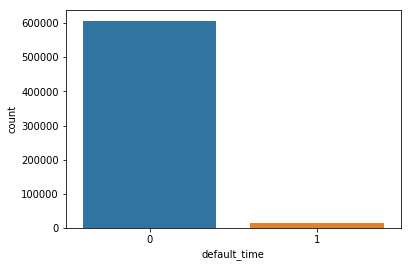

In [15]:
# Check how many default we have in the data set
sns.countplot(x='default_time', data=df)

We observe that the data set is heavily imbalanced. There are barely any defaults. To mitigate this issue, we will use an oversampling technique called SMOTE.

### Number of unique borrowers

In [16]:
print('The number of unique borrowers is: ', len(df['Borrower'].unique()))

The number of unique borrowers is:  49982


### Macroeconomic environment

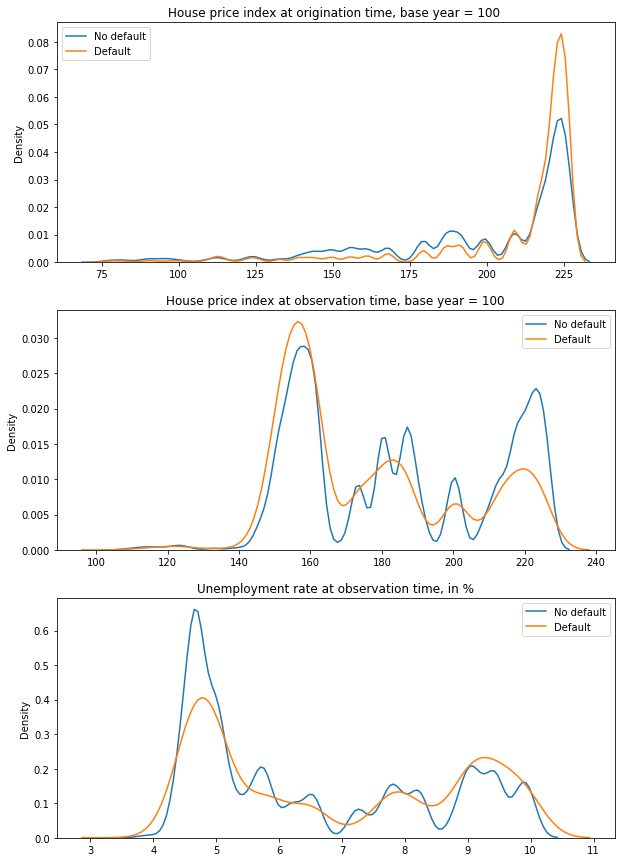

In [17]:
plt.figure(figsize = (10, 15))
labels = ['House price index at origination time, base year = 100 ','House price index at observation time, base year = 100', 'Unemployment rate at observation time, in %']
# iterate through the new features
for i, feature in enumerate(['hpi_orig_time', 'hpi_time', 'uer_time']):
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['default_time'] == 0, feature], label = 'No default')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['default_time'] == 1, feature], label = 'Default')
    
    # Label the plots
    plt.title(labels[i])
    plt.ylabel('Density');

### Parameters of a loan at origination

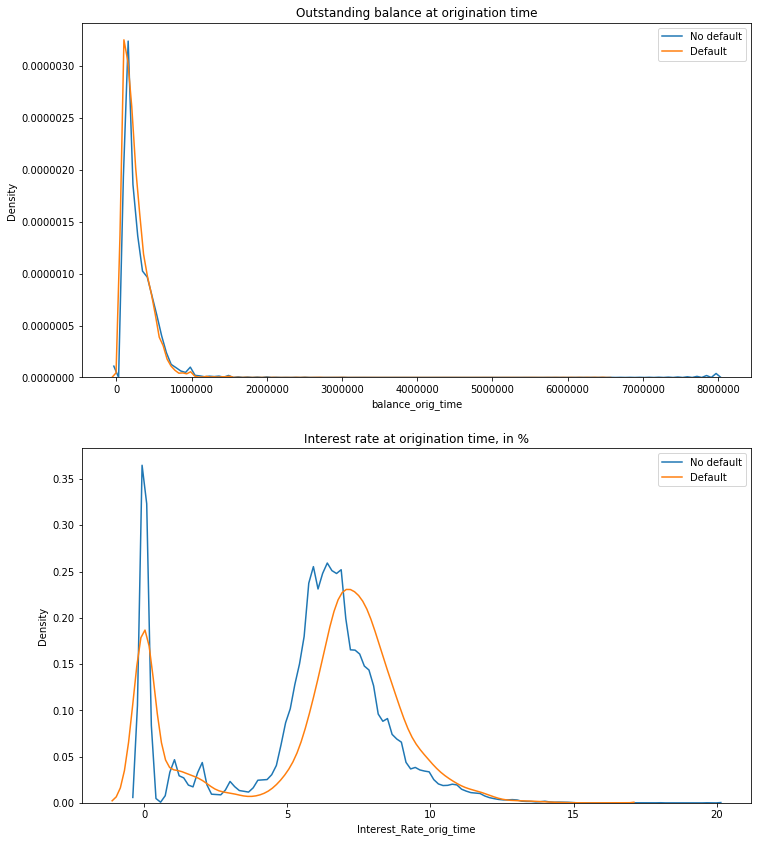

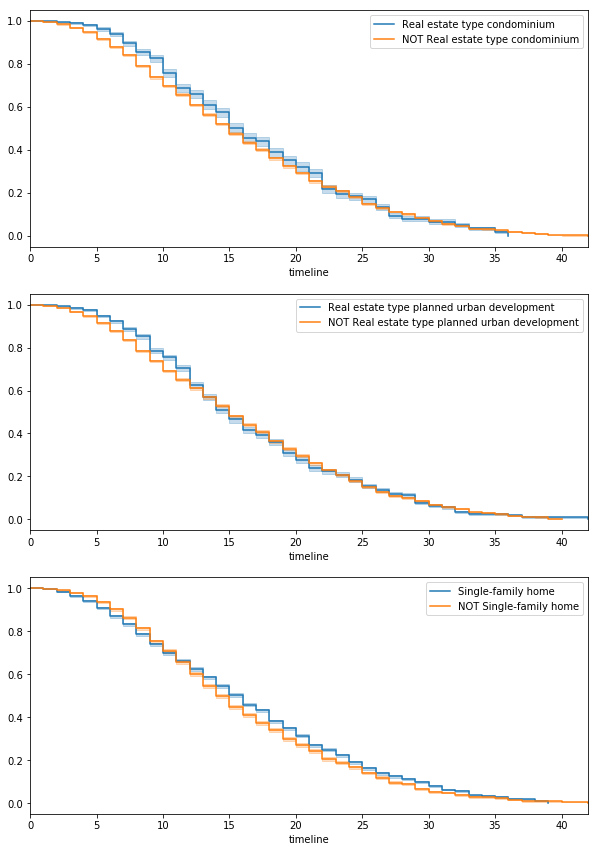

In [18]:
plt.figure(figsize = (12, 30))
labels = ['Outstanding balance at origination time', 'Interest rate at origination time, in %']
# iterate through the new features
for i, feature in enumerate(['balance_orig_time', 'Interest_Rate_orig_time']):
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['default_time'] == 0, feature], label = 'No default')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['default_time'] == 1, feature], label = 'Default')
    
    # Label the plots
    plt.title(labels[i])
    plt.xlabel('%s' % feature); plt.ylabel('Density');
binary_features = ['REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time']
T = dfs2["Duration"]
E = ~(dfs2["default_time"])
labels = ['Real estate type condominium', 'Real estate type planned urban development', 'Single-family home']

fig, axes = plt.subplots(len(binary_features), 1, figsize=(10, 20))
for i,feature in enumerate(binary_features):
    subset = (dfs2[feature] == 1)
    ax = plt.subplot(4,1,i+1)
    kmf.fit(T[subset], event_observed=E[subset], label=labels[i])
    kmf.plot(ax=ax)
    kmf.fit(T[~subset], event_observed=E[~subset], label="NOT " + labels[i])
    kmf.plot(ax=ax)

### Variable parameters of a loan

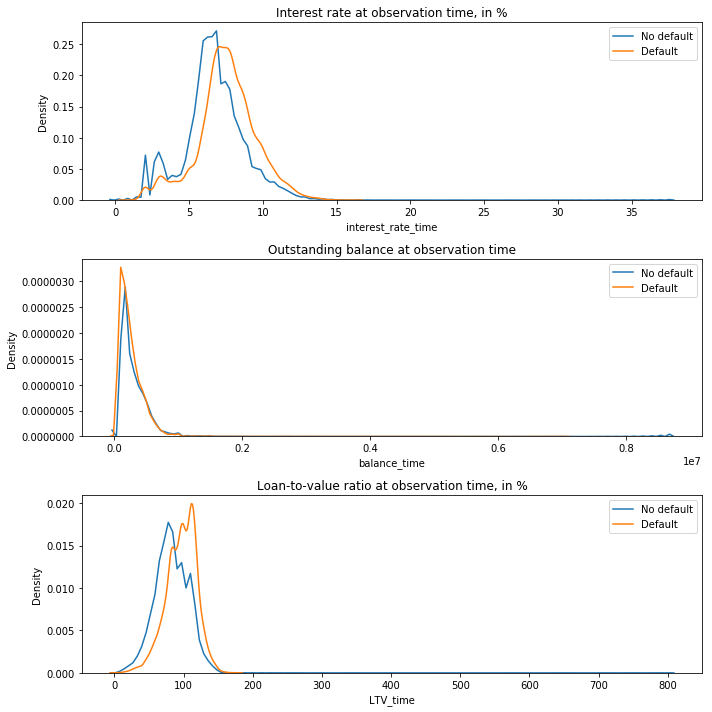

In [19]:
plt.figure(figsize = (10, 10))
labels = ['Interest rate at observation time, in %', 'Outstanding balance at observation time', 'Loan-to-value ratio at observation time, in %']
variables = ['interest_rate_time', 'balance_time', 'LTV_time']
# iterate through the new features
for i, feature in enumerate(variables):
    # create a new subplot for each source
    plt.subplot(len(variables), 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['default_time'] == 0, feature], label = 'No default')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['default_time'] == 1, feature], label = 'Default')
    
    # Label the plots
    plt.title(labels[i])
    plt.xlabel('%s' % feature); plt.ylabel('Density');
plt.tight_layout()

### Borrower characteristics

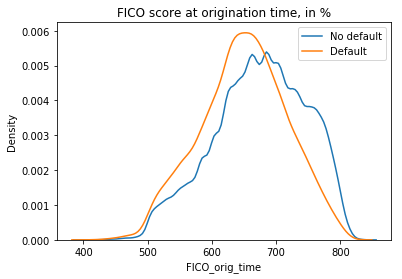

In [20]:
#plt.figure(figsize = (10, 10))
labels = ['FICO score at origination time, in %']
variables = ['FICO_orig_time']
# iterate through the new features
for i, feature in enumerate(variables):
    # create a new subplot for each source
    plt.subplot(len(variables), 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['default_time'] == 0, feature], label = 'No default')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['default_time'] == 1, feature], label = 'Default')
    # Label the plots
    plt.title(labels[i])
    plt.xlabel('%s' % feature); plt.ylabel('Density');

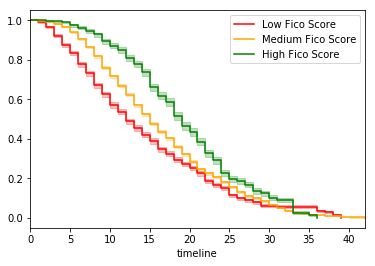

In [21]:
fico_category = pd.cut(dfs2.FICO_orig_time,bins=[0,620,750, 850],labels=['Low Fico Score','Medium Fico Score','High Fico Score'])
if 'Fico Category' in dfs2.columns:
    dfs2.drop(columns=['Fico Category'], inplace=True)
dfs2.insert(16,'Fico Category',fico_category)
fico_categories = ['Low Fico Score','Medium Fico Score','High Fico Score']
colors = ['red', 'orange', 'green']
ax = plt.subplot(1,1,1)
for i, cat in enumerate(fico_categories):
    kmf.fit(dfs2[dfs2['Fico Category'] == cat]['Duration'], ~dfs2[dfs2['Fico Category'] == cat]['default_time'])
    kmf.plot(ax=ax, label=cat, c=colors[i])   
    

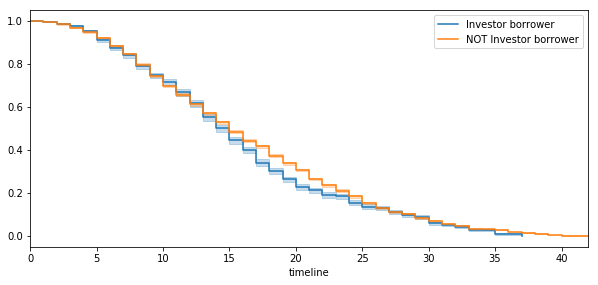

In [22]:
binary_features = ['investor_orig_time']
T = dfs2["Duration"]
E = ~(dfs2["default_time"])
labels = ['Investor borrower']
fig, axes = plt.subplots(len(binary_features), 1, figsize=(10, 20))
for i,feature in enumerate(binary_features):
    subset = (dfs2[feature] == 1)
    ax = plt.subplot(4,1,i+1)
    kmf.fit(T[subset], event_observed=E[subset], label=labels[i])
    kmf.plot(ax=ax)
    kmf.fit(T[~subset], event_observed=E[~subset], label="NOT " + labels[i])
    kmf.plot(ax=ax)

## Distribution plots for all variables

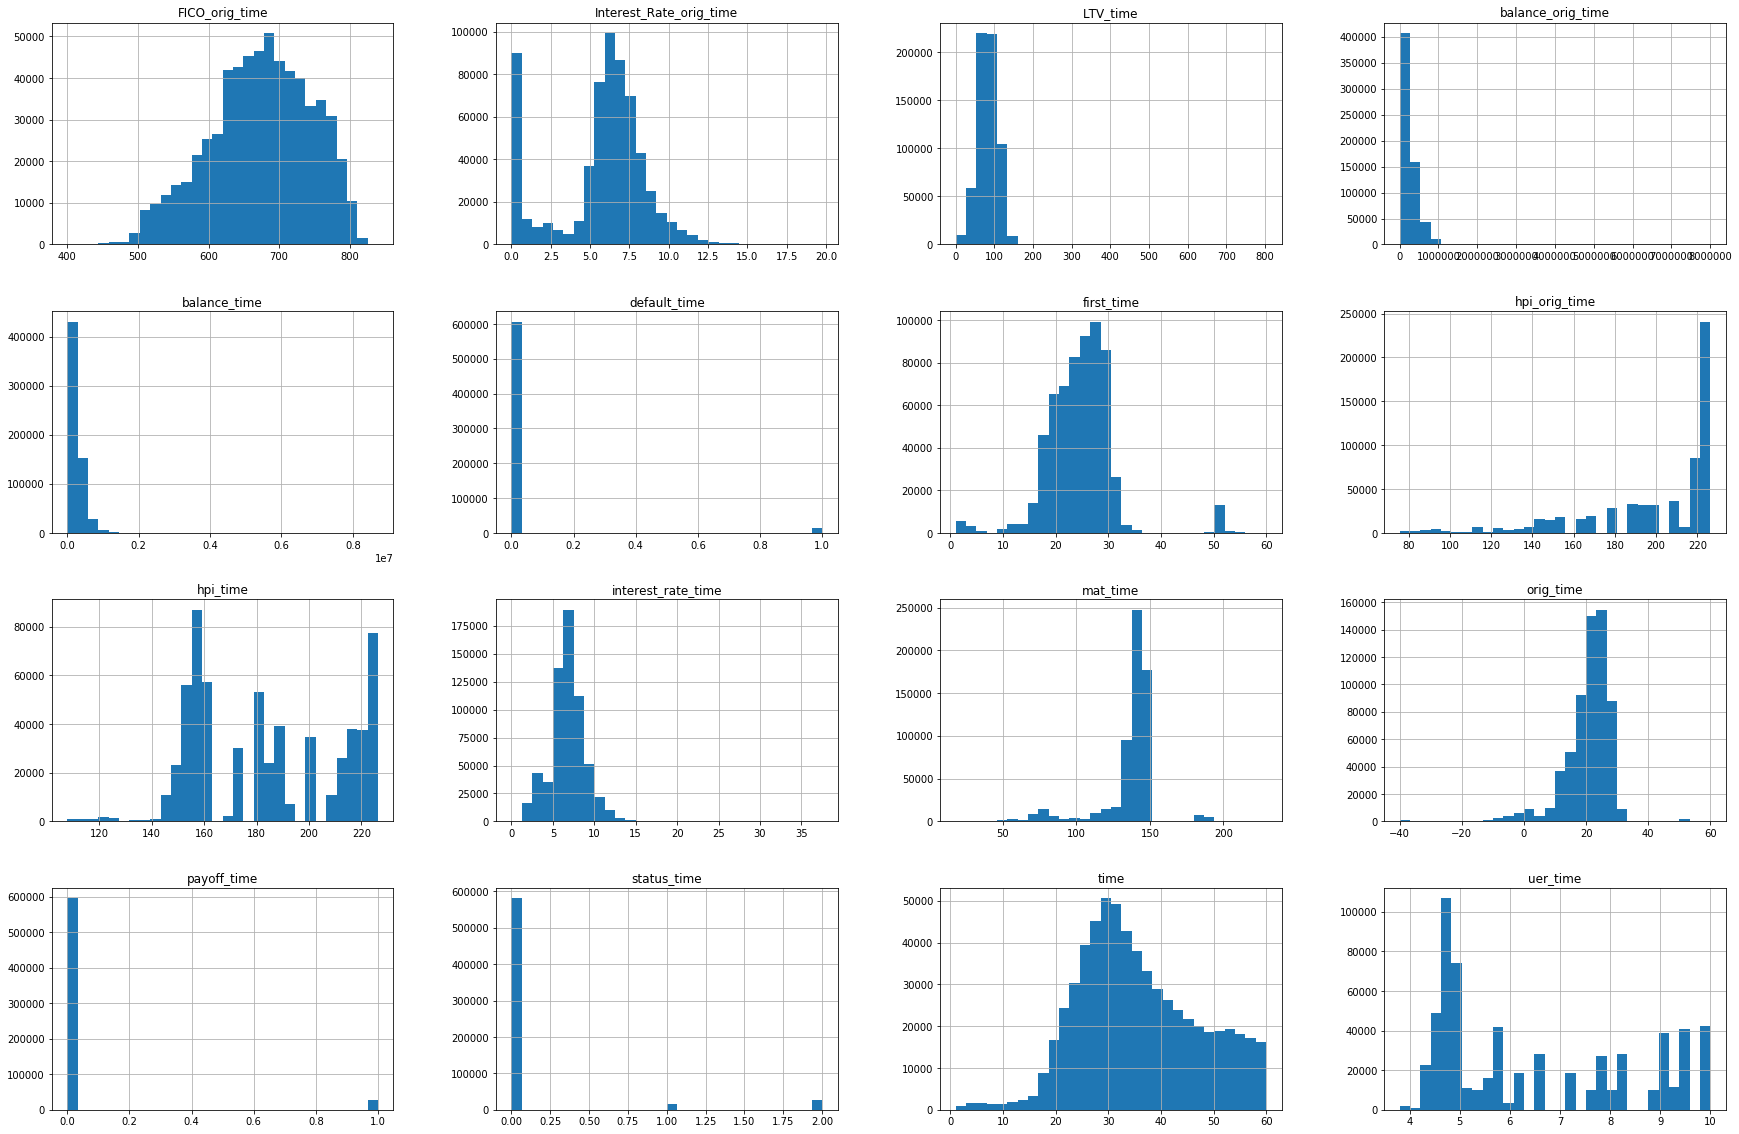

In [23]:
# Check the data distributions for every column
df.hist(bins=30, figsize=(30,20))
plt.show()

For some histograms, we see large unused spaced on the y axis. That signifies the presence of outliers. We will explore LTV_time, balance_orig_time, balance_time, interest_rate_time

## Boxplots for all continuous variables

In [24]:
df.select_dtypes(exclude=['object']).columns.tolist()

['time',
 'orig_time',
 'first_time',
 'mat_time',
 'balance_time',
 'LTV_time',
 'interest_rate_time',
 'hpi_time',
 'uer_time',
 'balance_orig_time',
 'FICO_orig_time',
 'Interest_Rate_orig_time',
 'hpi_orig_time',
 'default_time',
 'payoff_time',
 'status_time']

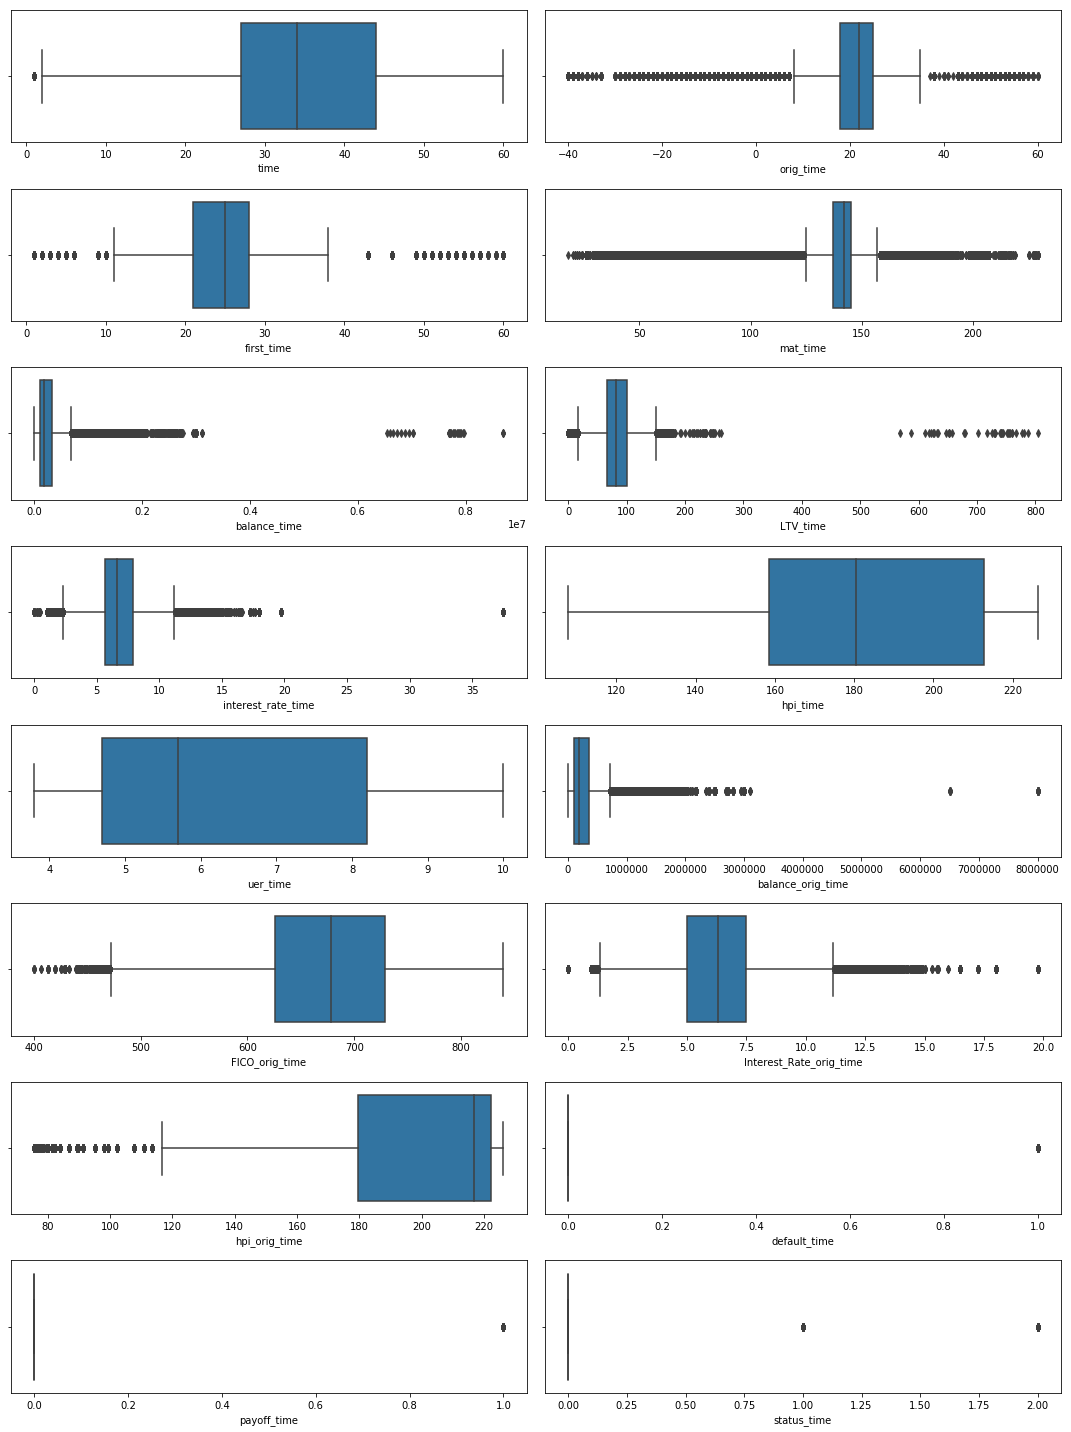

In [25]:
# Economic environment features
plt.figure(figsize = (15, 20))
# iterate through the new features
for i, column in enumerate(df.select_dtypes(exclude=['object']).columns.tolist()):
    # create a new subplot for each source, subplot(number of rows, number of columns, id of subplot)
    plt.subplot(8, 2, i+1)
    sns.boxplot(data=df, x=column)
plt.tight_layout()

The section below was used to manually remove outliers. However, when I tested the models with the outliers unremoved, it performed better. It might be due to the fact that I use the sklearn scaler or that the outliers were removed in a wrong way. In sum, I left the outliers untouched and commented out the code for manually removing them.

In [26]:
#Remove outliers to achieve a more normal distributions
dfc = df.copy()
# dfc = df[df['balance_time'] < 6000000]
# dfc = dfc[dfc['LTV_time'] < 500]
# dfc = dfc[dfc['interest_rate_time'] < 20]
# dfc = dfc[dfc['balance_orig_time'] < 6000000]
# dfc = dfc[dfc['Interest_Rate_orig_time'] < 20]

# Variable selection

In [27]:
#Check how the defaulted rows look like
dfc[dfc['default_time'] == 1].head()

,Borrower,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
23,1,48,-7,25,113,29087.21,26.658065,9.200,146.45,8.3,0,0,1,0,45000.0,715,9.20,87.03,1,0,1
99,6,56,19,25,139,190474.11,75.834755,6.580,181.43,6.6,0,0,1,0,212000.0,670,6.58,191.42,1,0,1
115,9,37,18,25,138,130140.31,99.138105,8.000,153.35,9.0,0,0,1,0,128000.0,501,8.00,186.91,1,0,1
120,10,29,18,25,139,88046.35,67.296390,10.230,217.37,4.5,0,0,1,0,90000.0,665,7.20,186.91,1,0,1
146,16,34,18,25,138,160044.34,73.431289,9.875,173.35,5.8,0,0,1,0,164500.0,572,7.50,186.91,1,0,1


## Correlation matrix

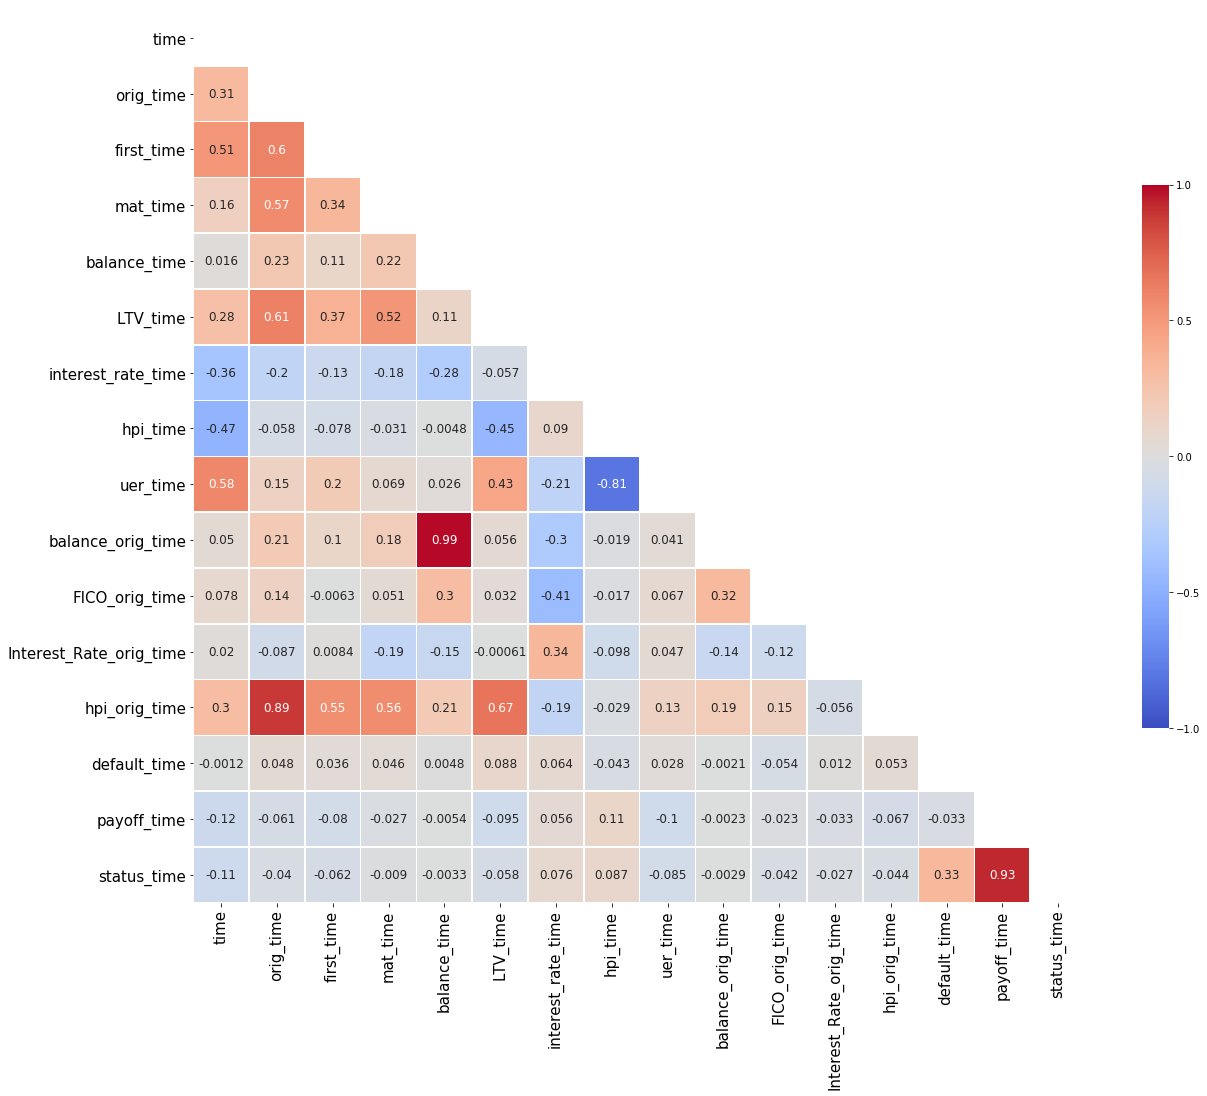

In [28]:
corr_matrix = dfc.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
f, ax = plt.subplots(figsize=(20, 25)) 
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
ax.tick_params(labelsize=15)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

We see no perfect correlation, therefore, we do not need to drop any variables.

### Define predictors

Basic predictor selection based on common sense

In [30]:
#Subset a data not to include the last three columns. Those columns are default_time, payoff_time, status_time. 
#They are related to the target variable, and therefore we dont want them in our X variable
X = dfc[dfc.columns[1:-3]]
dfc.columns[1:-3]

Index(['time', 'orig_time', 'first_time', 'mat_time', 'balance_time',
       'LTV_time', 'interest_rate_time', 'hpi_time', 'uer_time',
       'REtype_CO_orig_time', 'REtype_PU_orig_time', 'REtype_SF_orig_time',
       'investor_orig_time', 'balance_orig_time', 'FICO_orig_time',
       'Interest_Rate_orig_time', 'hpi_orig_time'],
      dtype='object')

### Define target variable

In [31]:
y = dfc['default_time']

## Variable selection through correlation
The idea is to see which independent variables are strong correlated with the target variable. In this case, the threshold is 0.5. It yields only the target variable itself. Therefore, we must use another method.

In [32]:
#Selecting highly correlated features
high_corr_features = corr_matrix[(abs(corr_matrix) > 0.8) & (corr_matrix != 1)]
high_corr_features = high_corr_features.dropna(axis=1, how='all')

In [33]:
high_corr_features

,orig_time,balance_time,hpi_time,uer_time,balance_orig_time,hpi_orig_time,payoff_time,status_time
time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orig_time,NaN,NaN,NaN,NaN,NaN,0.886296,NaN,NaN
first_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mat_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance_time,NaN,NaN,NaN,NaN,0.985177,NaN,NaN,NaN
LTV_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interest_rate_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hpi_time,NaN,NaN,NaN,-0.811461,NaN,NaN,NaN,NaN
uer_time,NaN,NaN,-0.811461,NaN,NaN,NaN,NaN,NaN
balance_orig_time,NaN,0.985177,NaN,NaN,NaN,NaN,NaN,NaN


Lets drop orig_time, balance_time, hpi_time because of high multicolinearity.

In [34]:
# drop by Name
X = X.drop(['orig_time', 'balance_time', 'hpi_time'], axis=1)

## Variable selection through Feature Importance 
Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.<br>
I fit a random forest on the data, then created a DataFrame with the improtances and the features and selected only features <br> with importance higher than 0.05. (arbitrary threshold which cuts out the binary variables who naturally have a lowee variance)
<br> Source: https://machinelearningmastery.com/feature-selection-machine-learning-python/

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
# load data
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, y)
print(model.feature_importances_)

[0.08349057 0.0623258  0.07059034 0.16763307 0.1205299  0.05678918
 0.00491261 0.00596746 0.01155812 0.00612766 0.13021501 0.12694113
 0.09385999 0.05905915]


In [36]:
dictionary = dict(zip(model.feature_importances_.tolist(), X.columns))

In [37]:
importance = pd.DataFrame(list(dictionary.items()), columns=['Importance', 'Feature'])

In [38]:
importance.sort_values(by='Importance', ascending=False)

,Importance,Feature
3,0.167633,LTV_time
10,0.130215,balance_orig_time
11,0.126941,FICO_orig_time
4,0.120530,interest_rate_time
12,0.093860,Interest_Rate_orig_time
0,0.083491,time
2,0.070590,mat_time
1,0.062326,first_time
13,0.059059,hpi_orig_time
5,0.056789,uer_time


In [39]:
# drop by Name
X = X.drop(['REtype_SF_orig_time', 'investor_orig_time', 'REtype_PU_orig_time', 'REtype_CO_orig_time'], axis=1)

### Create test/train split

In [40]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y.values, test_size=0.3, random_state=0)

### Normalize data

Some ML algorithms such as SVM require scaling, logistic regression, decision trees, and random forests do not

In [41]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train_raw)
X_test = stdsc.transform(X_test_raw)

# Define functions for model fitting, prediction and evaluation

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

### Create a dictionary with sklearn algorithms to be used

In [43]:
different_model_comparison = {
    "Random Forest":RandomForestClassifier(random_state=0,n_estimators=10),
    "Logistic Regression":LogisticRegression(random_state=0,  solver='lbfgs'),
    "Decision Tree":DecisionTreeClassifier(random_state=0),
    "XGBoost":xgb.XGBClassifier(objective="binary:logistic", random_state=42),
    "MLP":MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
     #"SVM":SVC(random_state=0,probability=True) #too slow never finished
}

### Component 1: Model fitting function

In [44]:
# function to train models, return a dictionary of trained models
# Input is the dictionary with ML models, we use the functions so that we can train more models at once
def train_model(model_dict,X_train,y_train):
    for model in model_dict:
        print("Training:",model)
        model_dict[model].fit(X_train,y_train)
    return model_dict

### Component 2: Model evaluation function

In [45]:
# Wrapping this function so we can easily change the model and evaluate them
# function to evaluate model performance 
from sklearn import metrics
def model_eval(clf_name,clf,X_test,y_test):
    print("Evaluating:",clf_name)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:,1]
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    report = pd.Series({
        "model":clf_name,
        "precision":metrics.precision_score(y_test, y_pred),
        "recall":metrics.recall_score(y_test, y_pred),
        "accuracy score":metrics.accuracy_score(y_test, y_pred),
        'roc_auc_score' : metrics.roc_auc_score(y_test, y_score)
    })
    return report,confusion_matrix

### Parent model fitting and evaluation function

In [46]:
def train_eval_model(model_dict,X_train,y_train,X_test,y_test):
    cols = ['model', 'roc_auc_score', 'precision', 'recall', 'accuracy score']
    model_report = pd.DataFrame(columns = cols)
    confusion_matrix_dict = {}
    model_dict = train_model(model_dict,X_train,y_train)
    for model in model_dict:
        report,confusion_matrix = model_eval(model,model_dict[model],X_test,y_test)
        model_report = model_report.append(report,ignore_index=True)
        confusion_matrix_dict[model] = confusion_matrix
        #confusion matrix
        plt.figure(figsize=(3,3))
        plt.title(model)
        sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        plt.xlabel('Model Prediction')
        plt.ylabel('Actual loan status')
    return model_report,confusion_matrix_dict

# Action! Model training and evaluating

## Train and evaluate model: Approach as covered in class

Training: Random Forest
Training: Logistic Regression
Training: Decision Tree
Training: XGBoost
Training: MLP
Evaluating: Random Forest
Evaluating: Logistic Regression
Evaluating: Decision Tree
Evaluating: XGBoost


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Evaluating: MLP


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


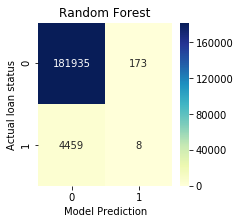

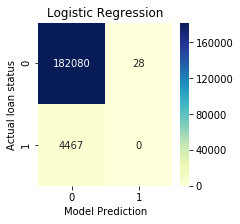

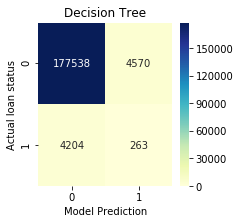

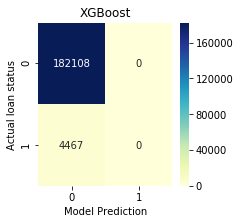

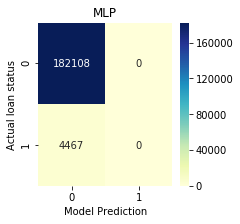

In [47]:
model_report,confusion_matrix_dict = train_eval_model(different_model_comparison,X_train,y_train,X_test,y_test)

In [48]:
#Model above poor, since they cannot predict loan defaults well
print("Defaulted loans in the dataset:", y_test[y_test == 1].shape[0])

Defaulted loans in the dataset: 4467


## Train and evaluate model: Oversampling approach

In [49]:
from imblearn.over_sampling import SMOTE

X_train_bal, y_train_bal = SMOTE(random_state=0).fit_sample(X_train,y_train)
X_test_bal, y_test_bal = X_test, y_test

In [50]:
#Compare train dataset used before and now. Now, the dataset is balanced in respect to default/non-default 
print("Share of defaulted loans in the original training dataset", sum(y_train)/len(y_train))
print("Share of defaulted loans in the oversampled training dataset", sum(y_train_bal)/len(y_train_bal))

Share of defaulted loans in the original dataset 0.024539496805937443
Share of defaulted loans in the oversampled dataset 0.5


Training: Random Forest
Training: Logistic Regression
Training: Decision Tree
Training: XGBoost
Training: MLP
Evaluating: Random Forest
Evaluating: Logistic Regression
Evaluating: Decision Tree
Evaluating: XGBoost
Evaluating: MLP


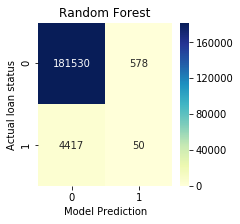

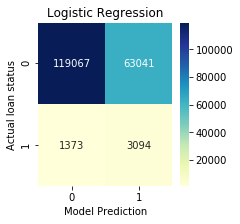

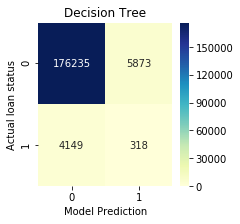

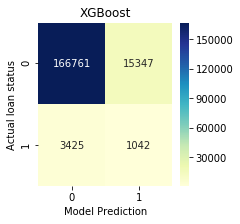

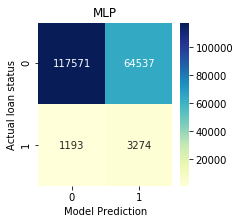

In [51]:
model_report_bal,cm_dict_bal = train_eval_model(different_model_comparison,X_train_bal,y_train_bal,X_test_bal,y_test_bal)

In [52]:
#Model above poor, since they cannot predict loan defaults well
print("Defaulted loans in the dataset:", y_test_bal[y_test_bal == 1].shape[0])

Defaulted loans in the dataset: 4467


### Compare the approaches above

In [53]:
model_report

,model,roc_auc_score,precision,recall,accuracy score
0,Random Forest,0.608173,0.044199,0.001791,0.975174
1,Logistic Regression,0.726111,0.000000,0.000000,0.975908
2,Decision Tree,0.516891,0.054418,0.058876,0.952973
3,XGBoost,0.758559,0.000000,0.000000,0.976058
4,MLP,0.750362,0.000000,0.000000,0.976058


In [54]:
model_report_bal

,model,roc_auc_score,precision,recall,accuracy score
0,Random Forest,0.627585,0.079618,0.011193,0.973228
1,Logistic Regression,0.728628,0.046783,0.692635,0.654755
2,Decision Tree,0.519469,0.051365,0.071189,0.946284
3,XGBoost,0.723225,0.063579,0.233266,0.899386
4,MLP,0.755964,0.048281,0.732930,0.647702


Notice the hight recall score for logistic regression in the second table. This is the best model

Models reports for balanced dataset with manual outlier removal in cell 16, compare with above.
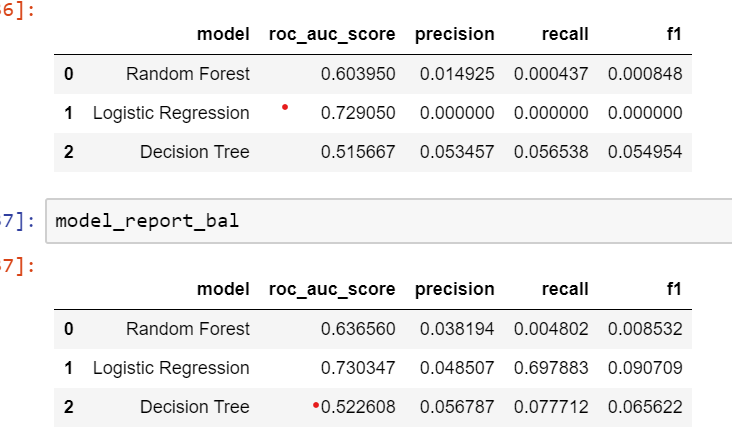